In [1]:
from glob import glob
from astroquery.mast import Mast, Observations
import os
import shutil
import numpy as np
import json
import requests
import asdf
from astropy import log
from astropy import wcs
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch, LinearStretch
from astropy.wcs.utils import skycoord_to_pixel
from astropy.nddata import extract_array

import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table

from align_to_catalogs import *
import astropy.units as u

import align_to_catalogs
from jwst import assign_wcs#.util.update_fits_wcsinfo
from jwst.datamodels import ImageModel


In [51]:
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['image.origin'] = 'lower'

In [52]:
os.environ["CRDS_PATH"] = "/orange/adamginsburg/jwst/brick/crds/"
os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

In [53]:
files = glob("/orange/adamginsburg/jwst/cloudc/F405N/pipeline/*destreak.fits")
files

['/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00001_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00002_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00002_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00001_nrcblong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00003_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00002_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcalong_destreak.fits',
 '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00003_nrcalong_destre

In [205]:
ref_image = '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak_copy.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak_realigned_to_vvv.fits'
file = '/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00002_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00002_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00002_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00004_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00003_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00001_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00004_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00001_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00003_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00002_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00003_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00002_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00003_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00001_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00002_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00002_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_02201_00001_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcblong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_08201_00001_nrcalong_destreak.fits'
#'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002001_08201_00004_nrcblong_destreak.fits'
align_image = file.split('.')[0]+'_align.fits'
shutil.copy(file, align_image)

'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00002_nrcblong_destreak_align.fits'

In [206]:
ref_fits = fits.open(ref_image)
ref_data = fits.open(ref_image)['SCI',1].data

In [207]:
pixel_scale = np.sqrt(fits.getheader(align_image, ext=1)['PIXAR_A2']*u.arcsec**2)
pixel_scale

<Quantity 0.06269025 arcsec>

In [208]:
align_image

'/orange/adamginsburg/jwst/cloudc/F405N/pipeline/jw02221002002_02201_00002_nrcblong_destreak_align.fits'

2023-08-29 13:37:15,417 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:819: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-25T04:14:05.933' from MJD-BEG.
Set DATE-AVG to '2023-04-25T04:14:32.775' from MJD-AVG.
Set DATE-END to '2023-04-25T04:14:59.617' from MJD-END'.
  warnings.warn(

2023-08-29 13:37:15,418 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:819: FITSFixedWarning: 'obsfix' made the change 'Set OBSGEO-L to  -120.023434 from OBSGEO-[XYZ].
Set OBSGEO-B to   -11.485975 from OBSGEO-[XYZ].
Set OBSGEO-H to 1386082407.725 from OBSGEO-[XYZ]'.
  warnings.warn(

2023-08-29 13:37:15,560 - stpipe - WARNING - /blue/adamginsburg/adamginsburg/repos/astropy/astropy/wcs/wcs.py:819: FITSFixedWarning: 'datfix' made the change 'Set DATE-BEG to '2023-04-25T04:14:05.933' from MJD-BEG.
Set DATE-AVG to '2023-04-25T04:14:32.775' from MJD-AVG.
Set DATE-END to '2023-04-25T04:14:59.617' from MJD-END'.
  

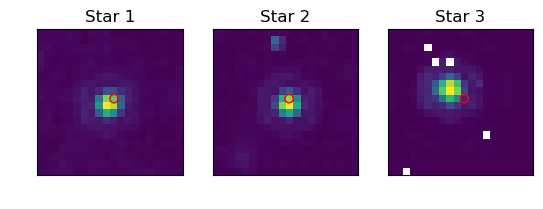

In [211]:
#02002_02201_00003_nrcbl
star_location = SkyCoord('17:46:17.9811789936','-28:35:42.3738317224',unit=(u.hourangle,u.deg))
star_location2 = SkyCoord('17:46:20.7437062304','-28:36:47.6472525487',unit=(u.hourangle,u.deg))
star_location3 = SkyCoord('17:46:23.4161884422','-28:35:22.1868251239',unit=(u.hourangle,u.deg))

#02002_08201_00001_nrcbl
#star_location = SkyCoord('17:46:18.8535027647','-28:34:38.7076845587',unit=(u.hourangle,u.deg))
#star_location2 = SkyCoord('17:46:18.5876737284','-28:35:28.8406921089',unit=(u.hourangle,u.deg))
#star_location3 = SkyCoord('17:46:24.2418605136','-28:35:08.1008023292',unit=(u.hourangle,u.deg))

##1002001_02201_00003_nrcblo
#star_location = SkyCoord('17:46:15.2083797761','-28:38:06.0376993433',unit=(u.hourangle,u.deg))
#star_location2 = SkyCoord('17:46:18.3002105976','-28:39:03.6362699361',unit=(u.hourangle,u.deg))
#star_location3 = SkyCoord('17:46:22.0306124391','-28:37:54.1817578554',unit=(u.hourangle,u.deg))

# 2_08201_nrca
#star_location = SkyCoord('17:46:20.4386265585','-28:31:33.2097415319',unit=(u.hourangle,u.deg))
#star_location2 = SkyCoord('17:46:21.5464835067','-28:32:59.3212374597',unit=(u.hourangle,u.deg))
#star_location3 = SkyCoord('17:46:27.1877425198','-28:32:50.1176777319',unit=(u.hourangle,u.deg))

#1_08201_nrca
#star_location = SkyCoord('17:46:17.4755800183','-28:33:29.4346915100',unit=(u.hourangle,u.deg))
#star_location2 = SkyCoord('17:46:18.1359630965','-28:33:40.6677512987',unit=(u.hourangle,u.deg))
#star_location3 = SkyCoord('17:46:25.3210055439','-28:34:05.7468224431',unit=(u.hourangle,u.deg))

#star_location = SkyCoord('17:46:24.0150084345','-28:32:40.8226642774',unit=(u.hourangle,u.deg))
#star_location2 = SkyCoord('17:46:18.1361450710','-28:33:40.6695075082',unit=(u.hourangle,u.deg))
#star_location3 = SkyCoord('17:46:23.7190259189','-28:34:01.0263844970',unit=(u.hourangle,u.deg))

#2001_02201_00004_nrcal
#star_location = SkyCoord('17:46:18.3588098638','-28:36:07.7030895747',unit=(u.hourangle,u.deg))
#star_location2 = SkyCoord('17:46:22.4969954193','-28:35:05.0118468859',unit=(u.hourangle,u.deg))
#star_location3 = SkyCoord('17:46:18.8536627456','-28:34:38.7115616933',unit=(u.hourangle,u.deg))

shutil.copy(file, align_image)
#align_image = imfile#glob.glob('mastDownload/JWST/*long*/*cal.fits')[0]
align_fits = fits.open(align_image)
align_fits_wcs = wcs.WCS(fits.getheader(align_image, ext=1))
align_fits['SCI',1].header['CRPIX1']+=(4*u.arcsec/pixel_scale).value
align_fits['SCI',1].header['CRPIX2']+=(1*u.arcsec/pixel_scale).value
align_fits.writeto(align_image,overwrite=True)

align_data = fits.open(align_image)['SCI',1].data
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

align_y2,align_x2 = skycoord_to_pixel(star_location2,wcs.WCS(align_fits['SCI',1],align_fits))

align_y3,align_x3 = skycoord_to_pixel(star_location3,wcs.WCS(align_fits['SCI',1],align_fits))


ref_y,ref_x = skycoord_to_pixel(star_location,wcs.WCS(ref_fits['SCI',1],ref_fits))
align_y,align_x = skycoord_to_pixel(star_location,wcs.WCS(align_fits['SCI',1],align_fits))

cutout_size=20.

align_cutout = extract_array(align_data,(cutout_size,cutout_size),(align_x,align_y))
norm1 = simple_norm(np.nan_to_num(align_cutout), stretch='log', max_percent=99.95, log_a=1)#simple_norm(align_cutout,stretch='linear',min_cut=-.5,max_cut=3)

align_cutout2 = extract_array(align_data,(cutout_size,cutout_size),(align_x2,align_y2))
norm2 = simple_norm(np.nan_to_num(align_cutout2), stretch='log', max_percent=99.95, log_a=1)

align_cutout3 = extract_array(align_data,(cutout_size,cutout_size),(align_x3,align_y3))
norm3 = simple_norm(np.nan_to_num(align_cutout3), stretch='log', max_percent=99.95, log_a=1)

fig,axes = plt.subplots(1,3)
axes[0].imshow(align_cutout, origin='lower',
                      norm=norm1)
axes[0].scatter(cutout_size/2, cutout_size/2, edgecolor='r', facecolor='none')
axes[0].set_title('Star 1')
axes[0].tick_params(labelcolor='none',axis='both',color='none')

axes[1].imshow(align_cutout2, origin='lower',
                      norm=norm2)
axes[1].scatter(cutout_size/2, cutout_size/2, edgecolor='r', facecolor='none')
axes[1].set_title('Star 2')
axes[1].tick_params(labelcolor='none',axis='both',color='none')

axes[2].imshow(align_cutout3, origin='lower',
                      norm=norm3)
axes[2].scatter(cutout_size/2, cutout_size/2, edgecolor='r', facecolor='none')
axes[2].set_title('Star 3')
axes[2].tick_params(labelcolor='none',axis='both',color='none')

plt.show()
